In [1]:
import numpy as np
import pandas as pd

import matplotlib
%matplotlib inline

In [2]:
housing = pd.read_csv('../datasets/housing/housing.csv')

In [3]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


# 1. Try a Support Vector Machine Regressor

In [58]:
tmp = housing.copy()

Add the extra features:

In [61]:
tmp["rooms_per_household"]       = tmp["total_rooms"] / tmp["households"]
tmp["bedrooms_per_room"]         = tmp["total_bedrooms"] / tmp["total_rooms"]
tmp["population_per_household"]  = tmp["population"] / tmp["households"]
tmp['income_cat']                = np.ceil(tmp['median_income'].div(1.5)).clip(1,5)

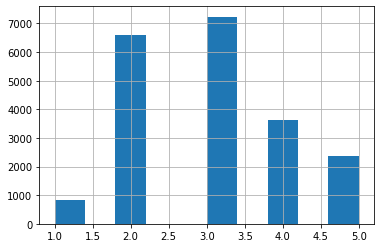

In [62]:
tmp['income_cat'].hist()

Add one-hot encoding:

In [63]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()
encoded = encoder.fit_transform(tmp['ocean_proximity'].values[:, None])

In [64]:
tmp = pd.concat([
    tmp.drop(columns='ocean_proximity'),
    pd.DataFrame(encoded.toarray(), columns=np.ravel(encoder.categories_))
], axis=1)

In [65]:
tmp.corr()['median_house_value'].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.688075
income_cat                  0.643892
<1H OCEAN                   0.256617
NEAR BAY                    0.160284
rooms_per_household         0.151948
NEAR OCEAN                  0.141862
total_rooms                 0.134153
housing_median_age          0.105623
households                  0.065843
total_bedrooms              0.049686
ISLAND                      0.023416
population_per_household   -0.023737
population                 -0.024650
longitude                  -0.045967
latitude                   -0.144160
bedrooms_per_room          -0.255880
INLAND                     -0.484859
Name: median_house_value, dtype: float64

Split the data into train and test sets

In [66]:
from sklearn.model_selection import StratifiedShuffleSplit

splitter = StratifiedShuffleSplit(n_splits=1, train_size=0.8, random_state=42)
for idx_train, idx_test in splitter.split(tmp, tmp['income_cat']):
    train = tmp.loc[idx_train]
    test = tmp.loc[idx_test]

In [69]:
from sklearn.preprocessing import StandardScaler

columns = train.columns.to_series()['longitude':'income_cat']
StandardScaler().fit_transform(tmp[columns])

array([[-1.32783522,  1.05254828,  0.98214266, ..., -1.1460242 ,
        -0.04959654,  1.89012782],
       [-1.32284391,  1.04318455, -0.60701891, ..., -0.98725423,
        -0.09251223,  1.89012782],
       [-1.33282653,  1.03850269,  1.85618152, ..., -1.44051403,
        -0.02584253,  1.89012782],
       ...,
       [-0.8237132 ,  1.77823747, -0.92485123, ...,  0.03680837,
        -0.0717345 , -0.95457381],
       [-0.87362627,  1.77823747, -0.84539315, ...,  0.11820445,
        -0.09122515, -0.95457381],
       [-0.83369581,  1.75014627, -1.00430931, ...,  0.14049521,
        -0.04368215, -0.95457381]])